<a href="https://www.kaggle.com/code/piotrpowroznik/seismic-wave-model?scriptVersionId=266442339" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Seismic Wave Model

Model representing propagation of acoustic waves is simulated in 500x500 grid with nodes spaced 1 meter apart. Source of acoustic waves is defined by the Ricker wavelet function and is located at the midpoint of the model at a depth of 25 meters. Ground medium consists of two layers upper with velocity of 1000 m/s, and the lower layer, where the velocity is 2000 m/s.

Ricker wavelet signal amplitude:
$$
A = (1-2\pi^2f^2t^2)e^{-\pi^2f^2t^2}
$$
Where f is the dominant frequency of the wavelet (Hz)

To ensure the accuracy of the simulation, absorbing boundary conditions were applied along all edges of the model.


## Initial Condition

In [1]:
library(animation)
library(IRdisplay)

In [2]:
licz <- 0  # Counter for tracking iterations

# Model parameters
nz <- 500   # Number of depth grid points
nx <- 500   # Number of horizontal grid points
fpeak <- 30.0  # Peak frequency
dt <- 0.002    # Time step
dt2 <- 0.02    # Alternative time step
et <- 0.5      # Total simulation time
ds <- 1.0      # Grid 


In [3]:
# Source location
xs <- nx / 2.0  # X position of the source
zs <- 25        # Z position of the source


In [4]:
# Number of time steps for the seismogram
nt <- et / dt + 1
st <- seq(0, et, length.out = nt)  # Time vector
ss <- matrix(nrow = nt, ncol = nx)  # Seismogram storage matrix

In [5]:
# Velocity model (initialization)
V <- matrix(nrow = nz, ncol = nx, 2000)  # Default velocity
for (i in 1:(nz / 2)) {
  for (j in 1:nx) {
    V[i, j] <- 1000  # Lower velocity in the upper layer
  }
}


In [6]:
# Pressure field matrices for time steps t+1, t, and t-1
p <- matrix(nrow = nz, ncol = nx, 0)
pm <- matrix(nrow = nz, ncol = nx, 0)
pp <- matrix(nrow = nz, ncol = nx, 0)

# Finding vmax for stability condition
vmax <- 2000

In [7]:
# dtr - real sampling step that is a divisor of dt
dtr <- ds / (2.0 * vmax)
w2 <- 0
while (1) {
  w2 <- w2 + 1
  w1 <- dt / w2
  if (w1 <= dtr) {
    dtr <- w1
    break
  }
}


In [8]:
# Progress bar initialization
niter <- et / dtr + 1
prog_bar <- txtProgressBar(min = 0, max = niter, style = 3)

kk <- 1  # Number of dtr per dt
kkk <- 0  # Number of dt steps
k <- 1    # Counter for dtr steps


  |                                                                      |   0%

## Wave Propagation Simulation 

In [9]:
saveGIF({
  while (1) {
    k <- k + 1
    kk <- kk + 1
    t <- k * dtr  # Current simulation time

    # Update progress bar
    setTxtProgressBar(prog_bar, k)

    # Main modeling loop
    for (i in 2:(nz - 1)) {
      for (j in 2:(nx - 1)) {
        pp[i, j] = 2.0 * p[i, j] - pm[i, j] + ((dtr * dtr) / (ds * ds)) * V[i, j] * V[i, j] *
          (p[i + 1, j] + p[i - 1, j] + p[i, j + 1] + p[i, j - 1] - 4.0 * p[i, j])
      }
    }

    # Adding Ricker wavelet source
    pp[zs, xs] <- pp[zs, xs] + exp(-(((pi * fpeak * (t - (1.0 / fpeak))) * (pi * fpeak * (t - (1.0 / fpeak)))))) *
      (1.0 - 2.0 * ((pi * fpeak * (t - (1.0 / fpeak))) * (pi * fpeak * (t - (1.0 / fpeak)))))

    # Transparent boundary conditions (absorbing)
    for (i in 1:nz) {
      pp[i, 1] = p[i, 1] + p[i, 2] - pm[i, 2] +
        V[i, 1] * (dtr / ds) * (p[i, 2] - p[i, 1] - (pm[i, 3] - pm[i, 2]))
        
      pp[i, nx] = p[i, nx] + p[i, nx - 1] - pm[i, nx - 1] +
        V[i, nx] * (dtr / ds) * (p[i, nx - 1] - p[i, nx] - (pm[i, nx - 2] - pm[i, nx - 1]))
    }
    for (i in 1:nx) {
      pp[1, i] = p[1, i] + p[2, i] - pm[2, i] +
        V[1, i] * (dtr / ds) * (p[2, i] - p[1, i] - (pm[3, i] - pm[2, i]))
        
      pp[nz, i] = p[nz, i] + p[nz - 1, i] - pm[nz - 1, i] +
        V[nz, i] * (dtr / ds) * (p[nz - 1, i] - p[nz, i] - (pm[nz - 2, i] - pm[nz - 1, i]))
    }

    # Advancing in time
    pm <- p
    p <- pp

    # Condition for saving a seismogram sample
    if (kk * dtr + dtr / 10.0 >= dt) {
      if (licz %% 10 == 0) {
        pimg <- apply(p, 2, rev)
        image(t(pimg))
      }
      licz <- licz + 1
      kk <- 0
      kkk <- kkk + 1
      ss[kkk, ] <- pp[1, ]  # Adding samples to the seismogram
      if (kkk * dt > et) break  # Stop condition
    }
  }
}, interval = 0.2)


  |                                                                      |   1%

  |=                                                                     |   1%

  |=                                                                     |   2%

  |==                                                                    |   2%

  |==                                                                    |   3%

  |==                                                                    |   4%

  |===                                                                   |   4%

  |===                                                                   |   5%

  |====                                                                  |   5%

  |====                                                                  |   6%

  |=====                                                                 |   6%

  |=====                                                                 |   7%

  |=====                                                                 |   8%

  |======                                                                |   8%

  |======                                                                |   9%

  |=======                                                               |   9%

  |=======                                                               |  10%

  |=======                                                               |  11%

  |========                                                              |  11%

  |========                                                              |  12%

  |=========                                                             |  12%

  |=========                                                             |  13%

  |=========                                                             |  14%

  |==========                                                            |  14%

  |==========                                                            |  15%

  |===========                                                           |  15%

  |===========                                                           |  16%

  |============                                                          |  16%

  |============                                                          |  17%

  |============                                                          |  18%

  |=============                                                         |  18%

  |=============                                                         |  19%

  |==============                                                        |  19%

  |==============                                                        |  20%

  |==============                                                        |  21%

  |===============                                                       |  21%

  |===============                                                       |  22%

  |================                                                      |  22%

  |================                                                      |  23%

  |================                                                      |  24%

  |=================                                                     |  24%

  |=================                                                     |  25%

  |==================                                                    |  25%

  |==================                                                    |  26%

  |===================                                                   |  26%

  |===================                                                   |  27%

  |===================                                                   |  28%

  |====================                                                  |  28%

  |====================                                                  |  29%

  |=====================                                                 |  29%

  |=====================                                                 |  30%

  |=====================                                                 |  31%

  |======================                                                |  31%

  |======================                                                |  32%

  |=======================                                               |  32%

  |=======================                                               |  33%

  |=======================                                               |  34%

  |========================                                              |  34%

  |========================                                              |  35%

  |=========================                                             |  35%

  |=========================                                             |  36%

  |==========================                                            |  36%

  |==========================                                            |  37%

  |==========================                                            |  38%

  |===========================                                           |  38%

  |===========================                                           |  39%

  |============================                                          |  39%

  |============================                                          |  40%

  |============================                                          |  41%

  |=============================                                         |  41%

  |=============================                                         |  42%

  |==============================                                        |  42%

  |==============================                                        |  43%

  |==============================                                        |  44%

  |===============================                                       |  44%

  |===============================                                       |  45%

  |================================                                      |  45%

  |================================                                      |  46%

  |=================================                                     |  46%

  |=================================                                     |  47%

  |=================================                                     |  48%

  |==================================                                    |  48%

  |==================================                                    |  49%

  |===================================                                   |  49%

  |===================================                                   |  50%

  |===================================                                   |  51%

  |====================================                                  |  51%

  |====================================                                  |  52%

  |=====================================                                 |  52%

  |=====================================                                 |  53%

  |=====================================                                 |  54%

  |======================================                                |  54%

  |======================================                                |  55%

  |=======================================                               |  55%

  |=======================================                               |  56%

  |========================================                              |  56%

  |========================================                              |  57%

  |========================================                              |  58%

  |=========================================                             |  58%

  |=========================================                             |  59%

  |==========================================                            |  59%

  |==========================================                            |  60%

  |==========================================                            |  61%

  |===========================================                           |  61%

  |===========================================                           |  62%

  |============================================                          |  62%

  |============================================                          |  63%

  |============================================                          |  64%

  |=============================================                         |  64%

  |=============================================                         |  65%

  |==============================================                        |  65%

  |==============================================                        |  66%

  |===============================================                       |  66%

  |===============================================                       |  67%

  |===============================================                       |  68%

  |================================================                      |  68%

  |================================================                      |  69%

  |=================================================                     |  69%

  |=================================================                     |  70%

  |=================================================                     |  71%

  |==================================================                    |  71%

  |==================================================                    |  72%

  |===================================================                   |  72%

  |===================================================                   |  73%

  |===================================================                   |  74%

  |====================================================                  |  74%

  |====================================================                  |  75%

  |=====================================================                 |  75%

  |=====================================================                 |  76%

  |======================================================                |  76%

  |======================================================                |  77%

  |======================================================                |  78%

  |=======================================================               |  78%

  |=======================================================               |  79%

  |========================================================              |  79%

  |========================================================              |  80%

  |========================================================              |  81%

  |=========================================================             |  81%

  |=========================================================             |  82%

  |==========================================================            |  82%

  |==========================================================            |  83%

  |==========================================================            |  84%

  |===========================================================           |  84%

  |===========================================================           |  85%

  |============================================================          |  85%

  |============================================================          |  86%

  |=============================================================         |  86%

  |=============================================================         |  87%

  |=============================================================         |  88%

  |==============================================================        |  88%

  |==============================================================        |  89%

  |===============================================================       |  89%

  |===============================================================       |  90%

  |===============================================================       |  91%

  |================================================================      |  91%

  |================================================================      |  92%

  |=================================================================     |  92%

  |=================================================================     |  93%

  |=================================================================     |  94%

  |==================================================================    |  94%

  |==================================================================    |  95%

  |===================================================================   |  95%

  |===================================================================   |  96%

  |====================================================================  |  96%

  |====================================================================  |  97%

  |====================================================================  |  98%

  |===================================================================== |  98%

  |===================================================================== |  99%

  |======================================================================|  99%

  |======================================================================| 100%

Output at: animation.gif



[1] TRUE

## Results
Animation visualizing wave propagation in the model area with a step 0.02 s

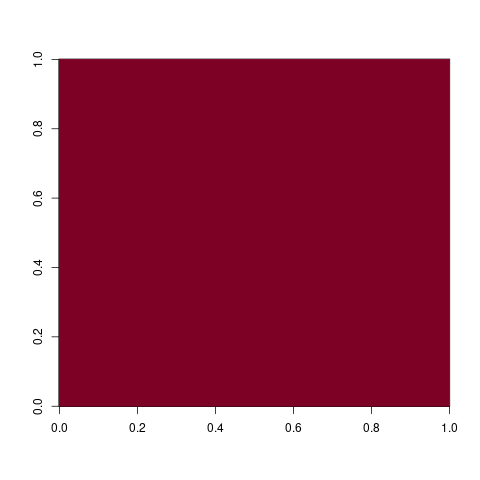

In [10]:
display_png(file = "animation.gif")

Wave propagation at the end of simulation.

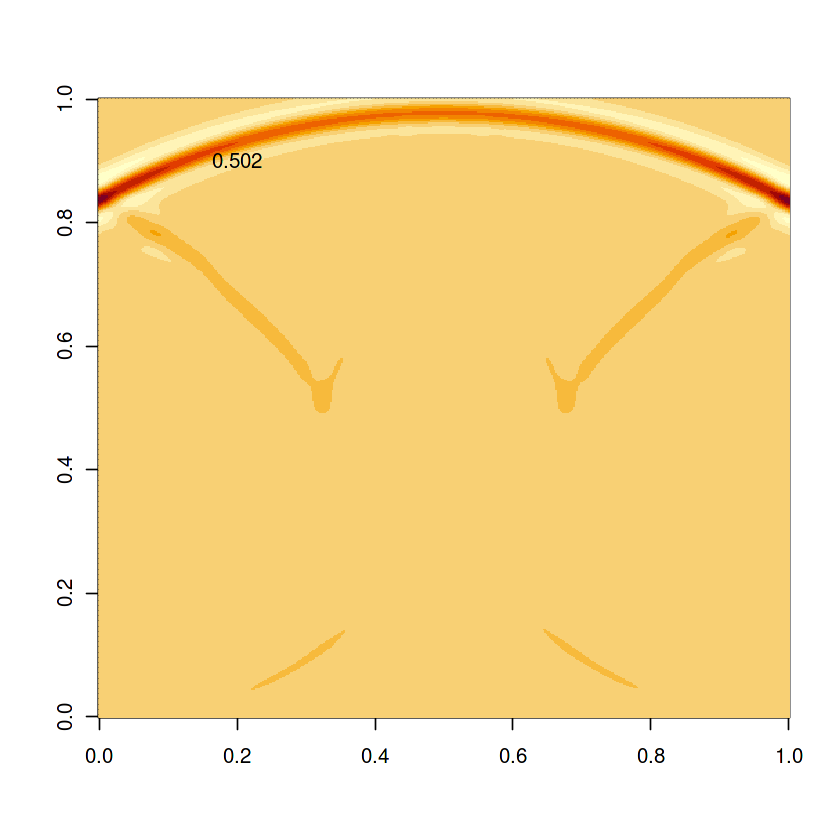

In [11]:
image(t(apply(p, 2, rev)))
text(0.2, 0.9, kkk * dt)


Sejsmogram presenting the method of reaching the wave to the upper edge of the model in time.

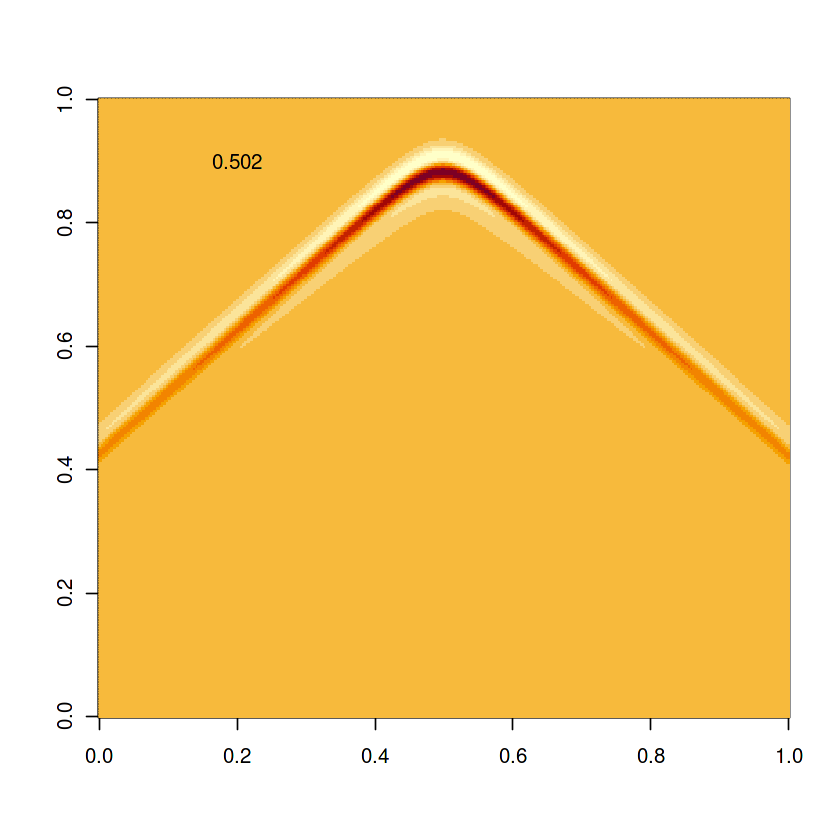

In [12]:
image(t(apply(ss, 2, rev)))
text(0.2, 0.9, kkk * dt)
